## Language Detection (of 10,000 Samples)

Dataset Source: https://www.kaggle.com/datasets/basilb2s/language-detection

#### Install Missing & Necessary Libraries

In [1]:
#%pip install --upgrade pip
#%pip install --upgrade datasets transformers evaluate 

#### Import Necessary Libraries

In [2]:
import sys, os
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datasets
from datasets import Dataset, DatasetDict

import torch

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, set_seed
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

import evaluate

!git lfs install

NOTE: Redirects are currently not supported in Windows or MacOs.


Git LFS initialized.


#### Display Versions of Libraries

In [3]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)

        Python: 3.9.12
         NumPy: 1.23.3
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1
         Torch: 1.12.1
      Evaluate: 0.4.0


#### Load Dataset

In [4]:
parent_dir = "/Users/briandunn/Desktop/Language Detection/10k-17 Languages"

df = pd.read_csv(os.path.join(parent_dir, "Language Detection.csv"))

df = df[df["Language"] != "Hindi"]
df = df.dropna()

df["Text"] = df["Text"].str.strip()
df["Language"] = df["Language"].str.strip()

# make sure that Swedish and Portuguese are spelt correctly for the model
# Change 'Sweedish' to 'Swedish' & 'Portugeese' to 'Portuguese'
df['Language'] = df['Language'].rename(
        {
            "Sweedish": "Swedish", 
            "Portugeese": "Portuguese"
        }
    )

# Change Feature names
df.rename(
    columns={
        "Text": "text", 
        "Language": "labels",
        },
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10274 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10274 non-null  object
 1   labels  10274 non-null  object
dtypes: object(2)
memory usage: 498.8+ KB


#### Visualize: Length Text Length (in Words)

The maximum length of this dataset is approximately 309 words.


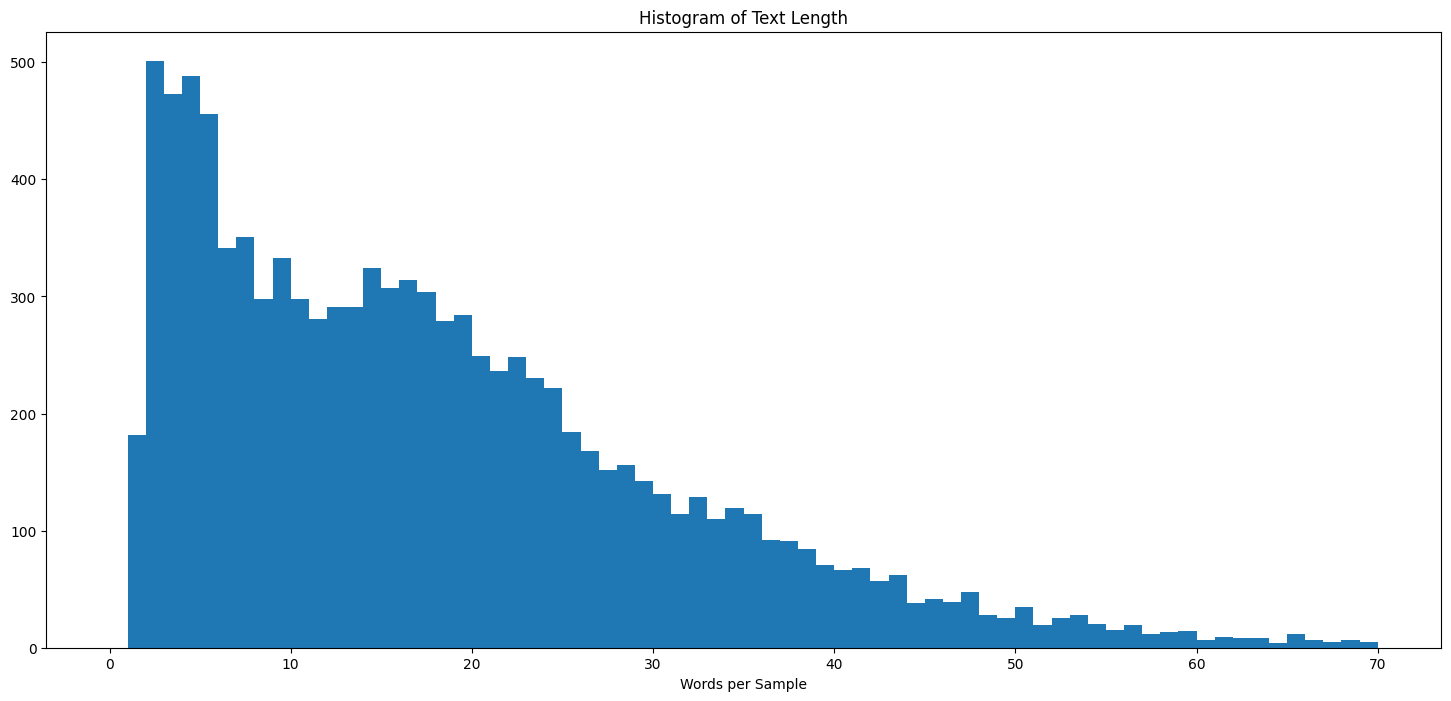

In [5]:
df['Text Length'] = df['text'].str.split().str.len()

max_len = df['Text Length'].max()
print(f"The maximum length of this dataset is approximately {max_len} words.")

n = 70
df.hist('Text Length', grid=False, figsize=(18,8), range=(0, n), bins=n)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Visualize: Length Text Length (in Words) By Language

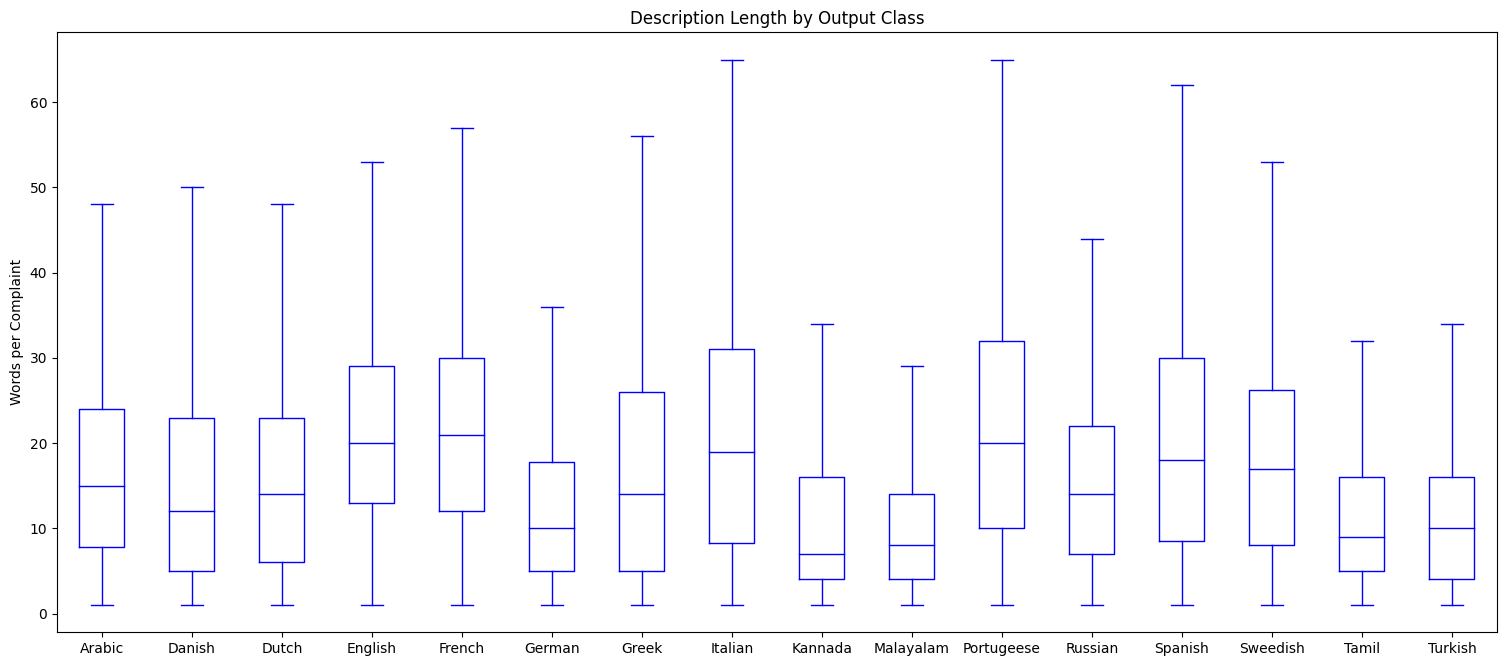

In [6]:
df.boxplot("Text Length", by="labels", grid=False, showfliers=False, color="Blue", figsize=(18, 8))

plt.suptitle('')
plt.title('Description Length by Output Class')
plt.xlabel('')
plt.ylabel('Words per Complaint')
plt.show()

#### Visualize: Number of Samples of Each Language

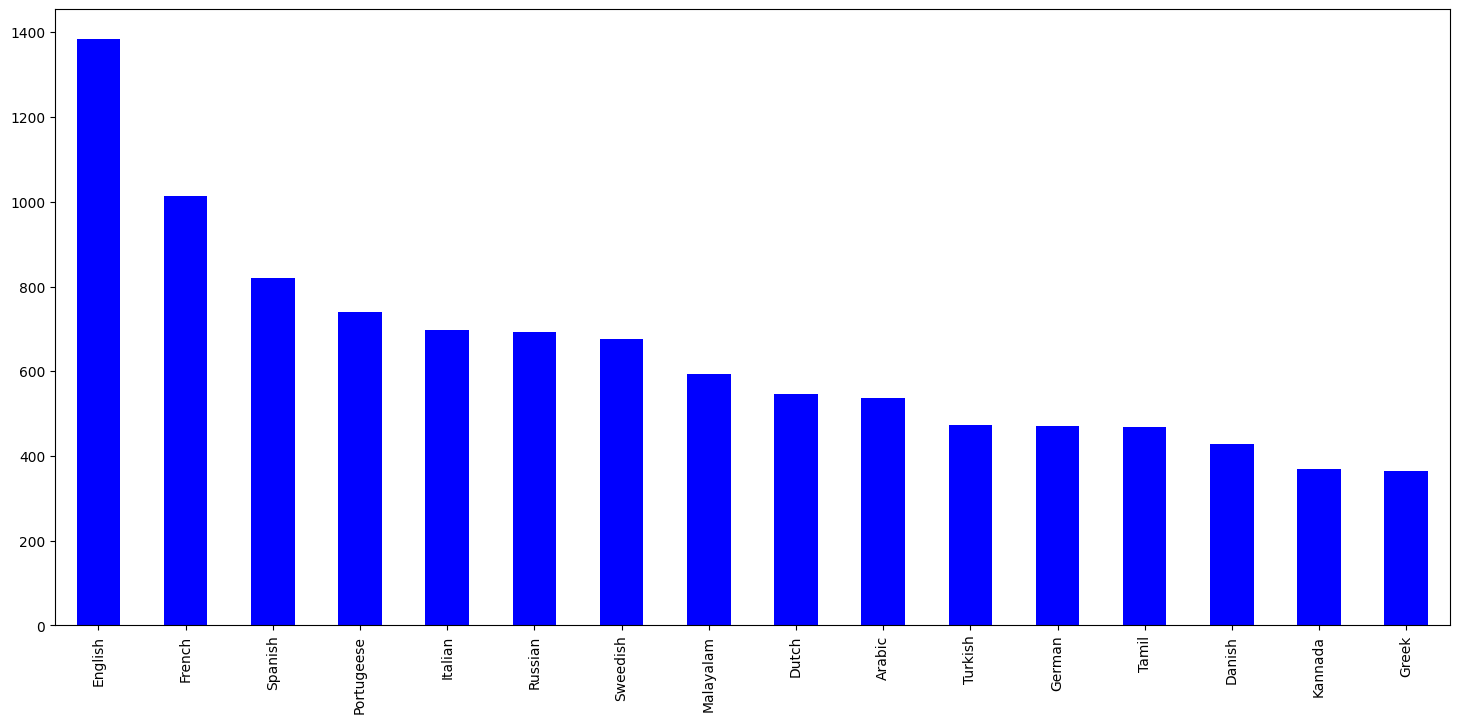

In [7]:
df['labels'].value_counts().plot(kind='bar', color="Blue", figsize=(18, 8))

plt.show()

#### Convert Labels Between String & Integer

In [8]:
LABEL_NAMES = list(set(df['labels']))
NUM_OF_LABELS = len(LABEL_NAMES)

id2label = dict(enumerate(LABEL_NAMES))
label2id = {v: k for k,v in id2label.items()}

print(LABEL_NAMES, '\n', NUM_OF_LABELS)
print("id2label:", id2label)
print("label2id:", label2id)

['Danish', 'Turkish', 'Malayalam', 'English', 'Russian', 'Spanish', 'Sweedish', 'German', 'French', 'Greek', 'Portugeese', 'Italian', 'Kannada', 'Arabic', 'Tamil', 'Dutch'] 
 16
id2label: {0: 'Danish', 1: 'Turkish', 2: 'Malayalam', 3: 'English', 4: 'Russian', 5: 'Spanish', 6: 'Sweedish', 7: 'German', 8: 'French', 9: 'Greek', 10: 'Portugeese', 11: 'Italian', 12: 'Kannada', 13: 'Arabic', 14: 'Tamil', 15: 'Dutch'}
label2id: {'Danish': 0, 'Turkish': 1, 'Malayalam': 2, 'English': 3, 'Russian': 4, 'Spanish': 5, 'Sweedish': 6, 'German': 7, 'French': 8, 'Greek': 9, 'Portugeese': 10, 'Italian': 11, 'Kannada': 12, 'Arabic': 13, 'Tamil': 14, 'Dutch': 15}


#### Final Preprocessing

In [9]:
# Replace String label values with Integer label values
df['labels'].replace(label2id, inplace=True)

# Remove overly lengthy samples
df = df[df["Text Length"] < 71]

# Remove unnecessary Feature
df.drop(columns=["Text Length"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10183 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10183 non-null  object
 1   labels  10183 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 238.7+ KB


#### Convert DataFrame to Dataset & Split into Train/Test/Eval Datasets

In [10]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test']
})

print('training data shape:', ds['train'].shape)
print('testing data shape:', ds['test'].shape)
print('validation data shape:', ds['eval'].shape)

training data shape: (8146, 3)
testing data shape: (1018, 3)
validation data shape: (1019, 3)


#### Basic Values/Constants

In [11]:
MODEL_CKPT = "distilbert-base-multilingual-cased"
              
MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-language_detection"

DEVICE = torch.device("cpu")
MAX_INPUT_LENGTH = int(70*1.30)

LEARNING_RATE = 2e-5
set_seed(42)

BATCH_SIZE = 64
NUM_OF_EPOCHS = 3

METRIC_NAME = "f1"
WEIGHT_DECAY = 0.01

REPORTS_TO = "tensorboard"
STRATEGY = "epoch"

#### Tokenize Entire Dataset

In [12]:
# Define the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

# Method to Tokenize each Sample in the Dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=MAX_INPUT_LENGTH)

# Map the 'Tokenize' Method to All Samples in the Entire Dataset
encoded_data = ds.map(tokenize, batched=True, batch_size=None)
encoded_data = encoded_data

print('training data shape:', encoded_data['train'].shape)
print('testing data shape:', encoded_data['test'].shape)
print('validation data shape:', encoded_data['eval'].shape)
print(encoded_data['train'][24])

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

training data shape: (8146, 5)
testing data shape: (1018, 5)
validation data shape: (1019, 5)
{'text': 'Mer komplicerad kodning av artiklar och mallar kan även göras i märkspråken html (för avancerad layout) och TeX (för matematiska formler och notskrift) samt programspråket Lua (för att skapa programmoduler som kan användas i avancerade mallar, och som körs på Mediawikiservern).', 'labels': 6, '__index_level_0__': 8367, 'input_ids': [101, 10734, 12240, 62631, 18599, 15328, 11269, 10170, 46118, 38255, 10177, 76437, 10354, 10905, 14127, 59805, 10107, 177, 181, 76743, 54609, 69379, 11062, 13222, 113, 10847, 41448, 18599, 71888, 114, 10177, 21452, 12674, 113, 10847, 43465, 106530, 10113, 12188, 10815, 10177, 10472, 65692, 114, 13611, 19316, 52302, 16343, 13650, 74564, 113, 10847, 10788, 31569, 11359, 12483, 11033, 42918, 10165, 10181, 10905, 91277, 177, 41448, 18752, 76437, 10354, 117, 10177, 10181, 68077, 10107, 10217, 13341, 92700, 12754, 38937, 114, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Instantiate Model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, 
                                                           num_labels=NUM_OF_LABELS,
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           ).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.we

#### Define Function to Compute Metrics

In [14]:
def compute_metrics(p):
    ### ------------------- Accuracy -------------------
    
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Define TrainingArguments

In [15]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_first_step=True,
    disable_tqdm=False,
    report_to=REPORTS_TO,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Data Collator

In [16]:
tokenized_datasets = encoded_data.remove_columns(ds["train"].column_names)
data_collator = DataCollatorWithPadding(tokenizer, padding=True)

#### Subclass Trainer to Correctly Compute Loss for Imbalanced Classes

In [17]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=torch.tensor(
                [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]
                )
            )
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#### Instantiate Trainer

In [18]:
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=encoded_data["train"],
    eval_dataset=encoded_data["eval"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Cloning https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection into local empty directory.


#### Train Model

In [19]:
train_results = trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 8146
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 384
  Number of trainable parameters = 135336976


A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 2.8224, 'learning_rate': 1.994791666666667e-05, 'epoch': 0.01}


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1019
  Batch size = 64


{'loss': 1.0783, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection/checkpoint-128
Configuration saved in distilbert-base-multilingual-cased-language_detection/checkpoint-128/config.json


{'eval_loss': 0.15443778038024902, 'eval_accuracy': 0.9823356231599607, 'eval_Weighted F1': 0.9818688279398573, 'eval_Micro F1': 0.9823356231599607, 'eval_Macro F1': 0.9805828778996699, 'eval_Weighted Recall': 0.9823356231599607, 'eval_Micro Recall': 0.9823356231599607, 'eval_Macro Recall': 0.9797963651863908, 'eval_Weighted Precision': 0.9846772481286562, 'eval_Micro Precision': 0.9823356231599607, 'eval_Macro Precision': 0.9852381510538253, 'eval_runtime': 210.5251, 'eval_samples_per_second': 4.84, 'eval_steps_per_second': 0.076, 'epoch': 1.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection/checkpoint-128/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/checkpoint-128/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/checkpoint-128/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/special_tokens_map.json
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation

{'loss': 0.1189, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection/checkpoint-256
Configuration saved in distilbert-base-multilingual-cased-language_detection/checkpoint-256/config.json


{'eval_loss': 0.05953313037753105, 'eval_accuracy': 0.9970559371933267, 'eval_Weighted F1': 0.9970530462874927, 'eval_Micro F1': 0.9970559371933267, 'eval_Macro F1': 0.9977369718278565, 'eval_Weighted Recall': 0.9970559371933267, 'eval_Micro Recall': 0.9970559371933267, 'eval_Macro Recall': 0.9973849347051074, 'eval_Weighted Precision': 0.997074923908581, 'eval_Micro Precision': 0.9970559371933267, 'eval_Macro Precision': 0.9981114357461582, 'eval_runtime': 203.6131, 'eval_samples_per_second': 5.005, 'eval_steps_per_second': 0.079, 'epoch': 2.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection/checkpoint-256/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/checkpoint-256/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/checkpoint-256/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1019
  Batch size = 64


{'loss': 0.0651, 'learning_rate': 0.0, 'epoch': 3.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection/checkpoint-384
Configuration saved in distilbert-base-multilingual-cased-language_detection/checkpoint-384/config.json


{'eval_loss': 0.04728417843580246, 'eval_accuracy': 0.9970559371933267, 'eval_Weighted F1': 0.9970530462874927, 'eval_Micro F1': 0.9970559371933267, 'eval_Macro F1': 0.9977369718278565, 'eval_Weighted Recall': 0.9970559371933267, 'eval_Micro Recall': 0.9970559371933267, 'eval_Macro Recall': 0.9973849347051074, 'eval_Weighted Precision': 0.997074923908581, 'eval_Micro Precision': 0.9970559371933267, 'eval_Macro Precision': 0.9981114357461582, 'eval_runtime': 203.3366, 'eval_samples_per_second': 5.011, 'eval_steps_per_second': 0.079, 'epoch': 3.0}


Model weights saved in distilbert-base-multilingual-cased-language_detection/checkpoint-384/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/checkpoint-384/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/checkpoint-384/special_tokens_map.json
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-multilingual-cased-language_detection/checkpoint-256 (score: 0.9970559371933267).


{'train_runtime': 15770.3698, 'train_samples_per_second': 1.55, 'train_steps_per_second': 0.024, 'train_loss': 0.42528709520896274, 'epoch': 3.0}


#### Evaluate Model

In [20]:
output_metrics = trainer.evaluate()

print(output_metrics)

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1019
  Batch size = 64


A Jupyter Widget

{'eval_loss': 0.05953313037753105, 'eval_accuracy': 0.9970559371933267, 'eval_Weighted F1': 0.9970530462874927, 'eval_Micro F1': 0.9970559371933267, 'eval_Macro F1': 0.9977369718278565, 'eval_Weighted Recall': 0.9970559371933267, 'eval_Micro Recall': 0.9970559371933267, 'eval_Macro Recall': 0.9973849347051074, 'eval_Weighted Precision': 0.997074923908581, 'eval_Micro Precision': 0.9970559371933267, 'eval_Macro Precision': 0.9981114357461582, 'eval_runtime': 206.7682, 'eval_samples_per_second': 4.928, 'eval_steps_per_second': 0.077, 'epoch': 3.0}


#### Push Fine-Tuned Model to HuggingFace Hub (My Profile!!!)

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-multilingual-cased-language_detection
Configuration saved in distilbert-base-multilingual-cased-language_detection/config.json
Model weights saved in distilbert-base-multilingual-cased-language_detection/pytorch_model.bin
tokenizer config file saved in distilbert-base-multilingual-cased-language_detection/tokenizer_config.json
Special tokens file saved in distilbert-base-multilingual-cased-language_detection/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection
   4cbcd02..f9f839f  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.9970559371933267}]}
To https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection
   f9f839f..86be9b0  main -> main



'https://huggingface.co/DunnBC22/distilbert-base-multilingual-cased-language_detection/commit/f9f839f99b25ff49e3679e36452093d3085454a0'

### Notes & Other Takeaways From This Projects
****
- The results exceeded my expectations!
- I removed the Hindi language samples as they were far longer than the samples for the other 16 languages. This was done to keep the training time as reasonable as possible.
****

### Citations

- Model Checkpoint
    - @article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}